# ![scikit-learn](https://img.shields.io/badge/scikit--learn-%23F7931E.svg?style=for-the-badge&logo=scikit-learn&logoColor=white) **CHAPTER 6 - DECISION TREES**

---

## **SETUP:**

In [2]:
# %load ../initial_settings.py
"""
Initial settings for data analysis and machine learning.
Use this with: %load ../initial_settings.py
"""

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import sklearn
from packaging import version

import matplotlib as mpl
import matplotlib.pyplot as plt

# This notebook requires Python 3.7 or above and Scikit-Learn 1.0.1 or above.
assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Graphviz source.
os.environ["PATH"] += os.pathsep + "C:/Programy/Graphviz/bin/"

# Default settings for matplotlib.
DARK_BLUE = "#03002e"
LIGHT_GRAY = "#8f8f99"

plt.rc("font", size=14)
plt.rc("legend", fontsize=14)
plt.rc("text", color=DARK_BLUE)

plt.rc("axes", labelsize=14)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelpad=10)
plt.rc("axes", labelcolor=DARK_BLUE)
plt.rc("axes", grid=True)

plt.rc("xtick", labelsize=12, color=DARK_BLUE)
plt.rc("ytick", labelsize=12, color=DARK_BLUE)
plt.rc("xtick.major", pad=10)
plt.rc("ytick.major", pad=10)

plt.rc("grid", color=LIGHT_GRAY)
plt.rc("grid", linestyle="dashed")
plt.rc("grid", linewidth=0.5)
plt.rc("grid", alpha=0.5)

# Create a directory for matplotlib images.
IMAGES_PATH = Path("images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, facecolor="w"):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor=facecolor)


---

## **TRAINING AND VISUALIZING A DECISION TREE:**

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values  # type: ignore
y_iris = iris.target  # type: ignore

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [4]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file=str(IMAGES_PATH / "iris_tree.dot"),
    feature_names=["petal length (cm)", "petal width (cm)"],
    class_names=iris.target_names,  # type: ignore
    rounded=True,
    filled=True
)

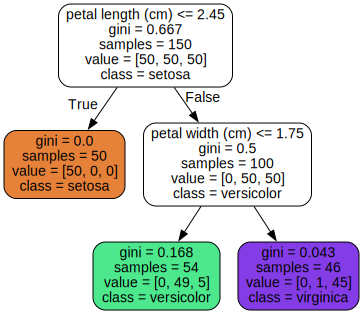

In [5]:
from graphviz import Source

Source.from_file(IMAGES_PATH / "iris_tree.dot")

Graphviz also provides the `dot` command line tool to convert `.dot` files to a variety of formats. The following command converts the dot file to a png image:

In [6]:
!dot -Tpng {IMAGES_PATH / "iris_tree.dot"} -o {IMAGES_PATH / "iris_tree.png"}

---

## **MAKING PREDICTIONS:**

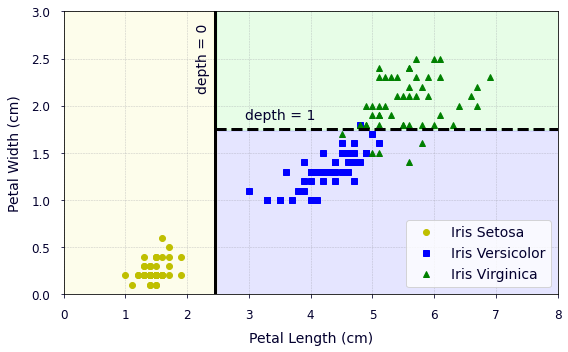

In [91]:
from matplotlib.colors import ListedColormap

lengths, widths = np.meshgrid(np.linspace(0, 8, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)  # Reshape for `contourf()`.
custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"], None)
th0, th1 = tree_clf.tree_.threshold[[0, 2]]

plt.figure(figsize=(8, 5))
plt.contourf(lengths, widths, y_pred, alpha=0.25, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):  # type: ignore
    petal_lengths = X_iris[:, 0][y_iris == idx]
    petal_widths = X_iris[:, 1][y_iris == idx]
    plt.plot(petal_lengths, petal_widths, style, label=f"Iris {name.title()}")

plt.axvline(th0, 0, 1, linestyle="solid", linewidth=3, color="black")
plt.axhline(th1, th0 / 8, 1, linestyle="dashed", linewidth=3, color="black")
plt.text(2.25, 2.50, "depth = 0", ha="center", va="center", fontsize=14, rotation=90)
plt.text(3.50, 1.90, "depth = 1", ha="center", va="center", fontsize=14)
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")
plt.legend(loc="lower right")

save_fig("decision_tree_boundaries")
plt.show()

---

## **ACCESSING THE TREE STRUCTURE:**

In [71]:
# Access to the tree.
tree = tree_clf.tree_

for attribute in ("node_count", "max_depth", "max_n_classes", "n_features",
                  "n_outputs", "n_leaves", "impurity"):
    print(attribute.ljust(15), getattr(tree, attribute))

node_count      5
max_depth       2
max_n_classes   3
n_features      2
n_outputs       1
n_leaves        3
impurity        [0.66666667 0.         0.5        0.16803841 0.04253308]


The root node is at index 0. The left and right children nodes of node _i_ are `tree.children_left[i]` and `tree.children_right[i]`. For example, the children of the root node are:

In [72]:
tree.children_left[0], tree.children_right[0]

(1, 2)

When the left and right nodes are equal, it means this is a leaf node (and the children node ids are arbitrary):

In [73]:
tree.children_left[3], tree.children_right[3]

(-1, -1)

So you can get the leaf node ids like this:

In [74]:
is_leaf = (tree.children_left == tree.children_right)
np.arange(tree.node_count)[is_leaf]

array([1, 3, 4])

Non-leaf nodes are called _split nodes_. The feature they split is available via the `feature` array. Values for leaf nodes should be ignored:

In [77]:
tree.feature  # 0 - feature 0, 1 - feature 1.

array([ 0, -2,  1, -2, -2], dtype=int64)

And the corresponding thresholds are:

In [76]:
tree.threshold

array([ 2.44999999, -2.        ,  1.75      , -2.        , -2.        ])

And the number of instances per class that reached each node is available too:

In [78]:
tree.value

array([[[50., 50., 50.]],

       [[50.,  0.,  0.]],

       [[ 0., 50., 50.]],

       [[ 0., 49.,  5.]],

       [[ 0.,  1., 45.]]])

In [79]:
tree.n_node_samples

array([150,  50, 100,  54,  46], dtype=int64)

In [81]:
assert tree.value.sum() == tree.n_node_samples.sum()

There's how you can compute the depth of each node:

In [85]:
def compute_depth(tree_clf):
    tree = tree_clf.tree_
    depth = np.zeros(tree.node_count)
    stack: list[tuple[int, int]] = [(0, 0)]  # (node, node_depth)
    
    while stack:
        node, node_depth = stack.pop()
        depth[node] = node_depth
        if tree.children_left[node] != tree.children_right[node]:
            stack.append((tree.children_left[node], node_depth + 1))
            stack.append((tree.children_right[node], node_depth + 1))
    
    return depth

depth = compute_depth(tree_clf)
depth

array([0., 1., 1., 2., 2.])

There's how to get the thresholds of all split nodes at depth 1:

In [89]:
is_leaf = (tree.children_left == tree.children_right)
tree.feature[(depth == 1) & (~is_leaf)]

array([1], dtype=int64)

In [90]:
tree.threshold[(depth == 1) & (~is_leaf)]

array([1.75])

---

## **ESTIMATING CLASS PROBABILITIES:**

In [92]:
petal_length = 5
petal_width = 1.5

tree_clf.predict_proba([[petal_length, petal_width]])

array([[0.        , 0.90740741, 0.09259259]])

In [97]:
pred_class = tree_clf.predict([[petal_length, petal_width]])
pred_class

array([1])

In [99]:
iris.target_names[pred_class]  # type: ignore

array(['versicolor'], dtype='<U10')

---

## **HYPERPARAMETERS REGULARIZATION:**

In [161]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=100, noise=0.25, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(random_state=42, min_samples_leaf=5)

tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

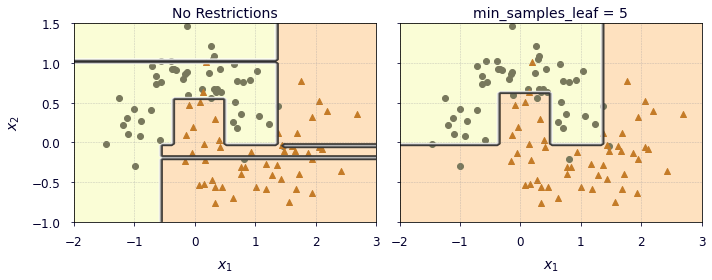

In [162]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.25, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.75)

    plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], color="#78785c", marker="o")
    plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], color="#c47b27", marker="^")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(ax1)
plot_decision_boundary(tree_clf1, X_moons, y_moons, axes=(-2, 3, -1, 1.5), cmap="Wistia")
plt.title("No Restrictions")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(ax2)
plot_decision_boundary(tree_clf2, X_moons, y_moons, axes=(-2, 3, -1, 1.5), cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.xlabel("$x_1$")

save_fig("min_samples_leaf")
plt.show()


In [165]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2, random_state=42)
tree_clf1.score(X_moons_test, y_moons_test)

0.927

In [166]:
tree_clf2.score(X_moons_test, y_moons_test)

0.951

---

## **REGRESSION:**

In [190]:
# Quadratic dataset.
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)

X_quad = np.random.rand(200, 1) - 0.5
y_quad = X_quad ** 2 + 0.02 * np.random.randn(200, 1)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X_quad, y_quad)

tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

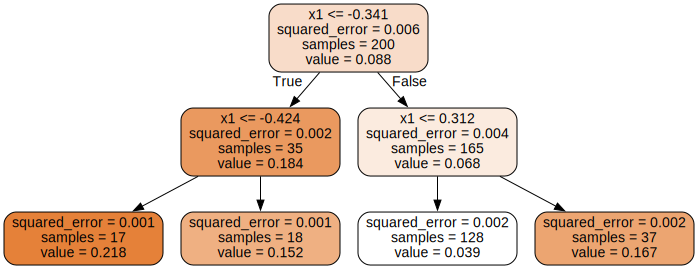

In [191]:
export_graphviz(
    tree_reg1,
    out_file=str(IMAGES_PATH / "regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True,
)
Source.from_file(IMAGES_PATH / "regression_tree.dot")

In [192]:
tree_reg1.tree_.threshold

array([-0.34138003, -0.42423472, -2.        , -2.        ,  0.31192939,
       -2.        , -2.        ])

In [193]:
tree_reg2.tree_.threshold

array([-0.34138003, -0.42423472, -0.46709116, -2.        , -2.        ,
       -0.3790482 , -2.        , -2.        ,  0.31192939, -0.28277655,
       -2.        , -2.        ,  0.40399227, -2.        , -2.        ])

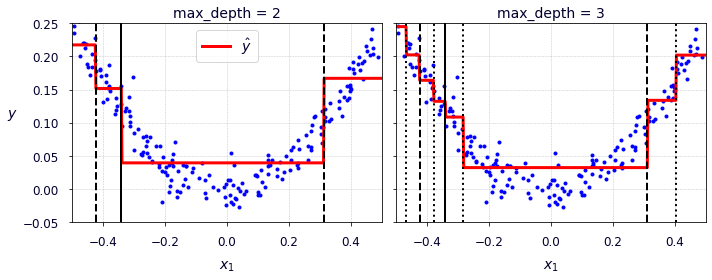

In [220]:
def plot_regression_predictions(tree_reg, X, y, axes=(-0.5, 0.5, -0.05, 0.25)):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r-", linewidth=3, label=r"$\hat{y}$")
    
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(ax1)
plot_regression_predictions(tree_reg1, X_quad, y_quad)
plt.title(f"max_depth = {tree_reg1.max_depth}")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")

th1s = tree_reg1.tree_.threshold[[0, 1, 4]]
for threshold, style in zip(th1s, ("-", "--", "--")):
    plt.axvline(threshold, 0, 1, linewidth=2, linestyle=style, color="black")    

plt.sca(ax2)
plot_regression_predictions(tree_reg2, X_quad, y_quad)
plt.title(f"max_depth = {tree_reg2.max_depth}")

th2s = tree_reg2.tree_.threshold[tree_reg2.tree_.threshold != -2]
for threshold, style in zip(th2s, ("-", "--", ":", ":", "--", ":", ":")):
    plt.axvline(threshold, 0, 1, linewidth=2, linestyle=style, color="black")  

save_fig("tree_regression")
plt.show()

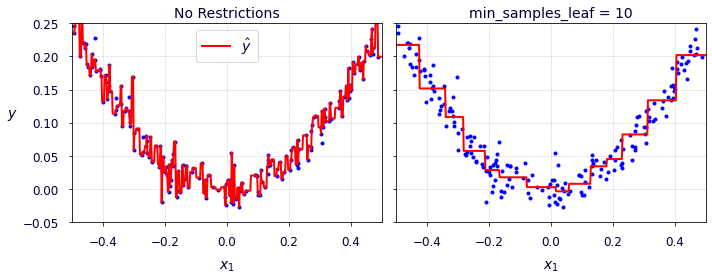

In [227]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)

tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(ax1)
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No Restrictions")

plt.sca(ax2)
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf = {tree_reg2.min_samples_leaf}")

save_fig("tree_regression_regularization")
plt.show()

---

## **SENSITIVITY TO AXIS ORIENTATION:**

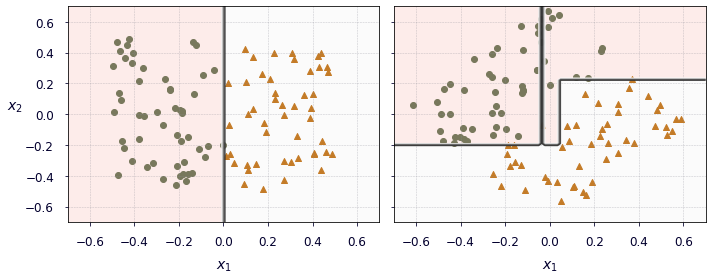

In [234]:
np.random.seed(42)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square @ rotation_matrix

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)

tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(ax1)
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=(-0.7, 0.7, -0.7, 0.7), cmap="Pastel1")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)

plt.sca(ax2)
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=(-0.7, 0.7, -0.7, 0.7), cmap="Pastel1")
plt.xlabel("$x_1$")

save_fig("sensitivity_to_rotation")
plt.show()


In [235]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

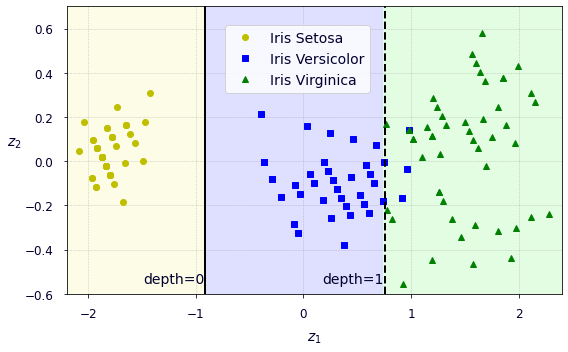

In [245]:
plt.figure(figsize=(8, 5))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name.title()}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "depth=0", ha="right", fontsize=14)
plt.text(th2 - 0.01, axes[2] + 0.05, "depth=1", ha="right", fontsize=14)
plt.axis(axes)
plt.legend(loc=(0.32, 0.70))

save_fig("pca_preprocessing")
plt.show()

---

## **DECISION TREES HAVE HIGH VARIANCE:**

We've seen that small changes in the dataset (such as a rotation) may produce a very different Decision Tree.
Now let's show that training the same model on the same data may produce a very different model every time, since the CART training algorithm used by Scikit-Learn is stochastic. To show this, we will set `random_state` to a different value than earlier:

In [246]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=40)

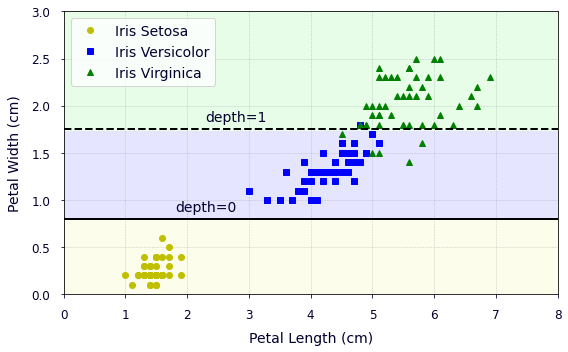

In [251]:
from matplotlib.colors import ListedColormap

lengths, widths = np.meshgrid(np.linspace(0, 8, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)  # Reshape for `contourf()`.
custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"], None)
th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]

plt.figure(figsize=(8, 5))
plt.contourf(lengths, widths, y_pred, alpha=0.25, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):  # type: ignore
    petal_lengths = X_iris[:, 0][y_iris == idx]
    petal_widths = X_iris[:, 1][y_iris == idx]
    plt.plot(petal_lengths, petal_widths, style, label=f"Iris {name.title()}")

plt.plot([0, 8], [th0, th0], "k-", linewidth=2)
plt.plot([0, 8], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "depth=0", verticalalignment="bottom", fontsize=14)
plt.text(2.3, th1 + 0.05, "depth=1", verticalalignment="bottom", fontsize=14)
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")
plt.legend(loc="upper left")

save_fig("decision_tree_boundaries")
plt.show()